# XU Method – Entropy-Based Anomaly Detection on CTU-13

Ce Notebook démontre l'approche XU, basée sur l'entropie, sur un dataset de type CTU-13.

### Étapes principales :
1. Import & Setup
2. Chargement de données (fichier binetflow)
3. Préprocessing (simplification des labels)
4. **Fonction `XU_algorithm`** qui calcule l'entropie par IP source
5. Application de la fonction XU et visualisation des résultats
6. Évaluation (matrice de confusion, précision, rappel, etc.)


## 1. Import & Setup

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm


%matplotlib inline
sns.set()
print("Libraries loaded.")

Libraries loaded.


## 2. Chargement de données
Nous supposons que vous avez déjà un fichier `.binetflow` extrait de CTU-13 (e.g. scenario 5).

In [47]:
import re

# Chemin du fichier d'origine
input_file = 'dataset\capture20110817.pcap.netflow.labeled'
# Chemin du fichier de sortie
output_file = 'dataset\capture20110817.pcap.netflow.labeled.csv'

with open(input_file, 'r', encoding='utf-8', errors='replace') as f:
    lines = f.readlines()

# Pour chaque ligne, remplace tous les groupes d'espaces par une virgule
converted_lines = [re.sub(r'\s+', ',', line.strip()) for line in lines]

# Écrit le résultat dans un nouveau fichier
with open(output_file, 'w', encoding='utf-8') as f:
    for line in converted_lines:
        f.write(line + "\n")

print("Fichier converti en CSV sauvegardé sous", output_file)


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kira\AppData\Local\Temp\ipykernel_17320\3106659421.py:4: SyntaxWarning: invalid escape sequence '\c'
  input_file = 'dataset\capture20110817.pcap.netflow.labeled'
C:\Users\kira\AppData\Local\Temp\ipykernel_17320\3106659421.py:6: SyntaxWarning: invalid escape sequence '\c'
  output_file = 'dataset\capture20110817.pcap.netflow.labeled.csv'


Fichier converti en CSV sauvegardé sous dataset\capture20110817.pcap.netflow.labeled.csv


In [2]:
# Chemin vers un fichier .binetflow
data_path = "dataset\capture20110817.pcap.netflow.labeled.csv"

df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')
print(f"Data shape: {df.shape}")
df.head(20)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kira\AppData\Local\Temp\ipykernel_17820\1584984224.py:2: SyntaxWarning: invalid escape sequence '\c'
  data_path = "dataset\capture20110817.pcap.netflow.labeled.csv"


Data shape: (8079338, 13)


,Date,flow_start,Durat,Prot,SrcIPAddr:Port,Direc,DstIPAddr:Port,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-17,12:01:01.780,3.124,UDP,188.75.133.98:16200,->,147.32.86.125:35248,INT,0,304,219158,1,Background
1,2011-08-17,12:01:01.782,4.922,TCP,119.252.172.92:59067,->,147.32.84.14:80,A_,0,39,2346,1,Background
2,2011-08-17,12:01:01.783,1.000,TCP,90.183.101.168:80,->,147.32.86.89:1176,FPA_,0,4,2905,1,Background
3,2011-08-17,12:01:01.783,4.996,TCP,217.169.177.82:56950,->,147.32.85.26:54145,PA_,0,433,27648,1,Background
4,2011-08-17,12:01:01.784,4.986,TCP,147.32.85.26:54145,->,217.169.177.82:56950,PA_,0,837,1173304,1,Background
5,2011-08-17,12:01:01.784,4.874,TCP,119.252.172.92:59066,->,147.32.84.14:80,A_,0,163,9990,1,Background
6,2011-08-17,12:01:01.784,0.000,TCP,89.185.253.133:443,->,147.32.86.107:51505,FPA_,0,3,455,1,Background
7,2011-08-17,12:01:01.784,4.874,TCP,147.32.84.14:80,->,119.252.172.92:59066,PA_,0,483,731262,1,Background
8,2011-08-17,12:01:01.785,0.998,TCP,147.32.86.89:1176,->,90.183.101.168:80,A_,0,2,120,1,Background
9,2011-08-17,12:01:01.785,0.000,TCP,147.32.86.107:51505,->,89.185.253.133:443,RPA_,0,2,151,1,Background


In [12]:
df["Date"].value_counts()

Date
2011-08-17    8079338
Name: count, dtype: int64

## 3. Préprocessing / Data Exploration
On convertit les labels (Botnet vs Normal).

In [ ]:
def preprocessing_dataset(df):
    """
    Sépare les informations d'IP et de port pour les colonnes 'SrcIPAddr:Port' et 'DstIPAddr:Port'.
    
    La fonction fait :
    - La séparation en deux colonnes pour chacune des colonnes concernées.
    - La suppression des colonnes d'origine.
    - La réorganisation des colonnes afin que les deux nouvelles colonnes remplacent la colonne d'origine
      (les ports se retrouvent à droite de leur adresse IP).
    
    Retourne le DataFrame modifié.
    """
    # Effectuer la séparation pour la source
    src_split = df["SrcIPAddr:Port"].str.split(":", expand=True)
    df["SrcIP"] = src_split[0]
    df["SrcPort"] = src_split[1]
    
    # Effectuer la séparation pour la destination
    dst_split = df["DstIPAddr:Port"].str.split(":", expand=True)
    df["DstIP"] = dst_split[0]
    df["DstPort"] = dst_split[1]
    
    # Sauvegarder l'ordre original connu
    original_cols = ["Date", "flow_start", "Durat", "Prot", 
                     "SrcIPAddr:Port", "Direc", "DstIPAddr:Port", 
                     "Flags", "Tos", "Packets", "Bytes", "Flows", "Label"]
    
    # Trouver les positions des colonnes à remplacer
    src_idx = original_cols.index("SrcIPAddr:Port")
    dst_idx = original_cols.index("DstIPAddr:Port")
    
    # Construire le nouvel ordre des colonnes :
    # - Conserver les colonnes avant la colonne source d'origine.
    new_order = original_cols[:src_idx]
    # - Remplacer "SrcIPAddr:Port" par "SrcIP" et "SrcPort"
    new_order.extend(["SrcIP", "SrcPort"])
    # - Conserver les colonnes entre la colonne source et la colonne destination d'origine
    new_order.extend(original_cols[src_idx+1:dst_idx])
    # - Remplacer "DstIPAddr:Port" par "DstIP" et "DstPort"
    new_order.extend(["DstIP", "DstPort"])
    # - Conserver le reste des colonnes après la colonne destination d'origine
    new_order.extend(original_cols[dst_idx+1:])
    
    # Supprimer les colonnes d'origine
    df = df.drop(columns=["SrcIPAddr:Port", "DstIPAddr:Port"])
    
    # Réorganiser le DataFrame selon le nouvel ordre
    df = df[new_order]
    
    return df

In [ ]:
df = preprocessing_dataset(df)
df.head(10)

,Date,flow_start,Durat,Prot,SrcIP,SrcPort,Direc,DstIP,DstPort,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-17,12:01:01.780,3.124,UDP,188.75.133.98,16200,->,147.32.86.125,35248,INT,0,304,219158,1,Background
1,2011-08-17,12:01:01.782,4.922,TCP,119.252.172.92,59067,->,147.32.84.14,80,A_,0,39,2346,1,Background
2,2011-08-17,12:01:01.783,1.000,TCP,90.183.101.168,80,->,147.32.86.89,1176,FPA_,0,4,2905,1,Background
3,2011-08-17,12:01:01.783,4.996,TCP,217.169.177.82,56950,->,147.32.85.26,54145,PA_,0,433,27648,1,Background
4,2011-08-17,12:01:01.784,4.986,TCP,147.32.85.26,54145,->,217.169.177.82,56950,PA_,0,837,1173304,1,Background
5,2011-08-17,12:01:01.784,4.874,TCP,119.252.172.92,59066,->,147.32.84.14,80,A_,0,163,9990,1,Background
6,2011-08-17,12:01:01.784,0.000,TCP,89.185.253.133,443,->,147.32.86.107,51505,FPA_,0,3,455,1,Background
7,2011-08-17,12:01:01.784,4.874,TCP,147.32.84.14,80,->,119.252.172.92,59066,PA_,0,483,731262,1,Background
8,2011-08-17,12:01:01.785,0.998,TCP,147.32.86.89,1176,->,90.183.101.168,80,A_,0,2,120,1,Background
9,2011-08-17,12:01:01.785,0.000,TCP,147.32.86.107,51505,->,89.185.253.133,443,RPA_,0,2,151,1,Background


In [7]:
def hist_of_label_values(df):
    """
    Affiche un histogramme de la répartition des labels dans le DataFrame,
    avec les pourcentages affichés sur les barres.
    
    Paramètres :
    - df : pd.DataFrame contenant une colonne 'Label' avec les valeurs 
           'Background', 'Normal' et 'Botnet'.
    
    Affichage :
    - Un histogramme avec les pourcentages sur les barres.
    - Un dictionnaire affiché contenant les pourcentages.
    """
    # Regroupement des valeurs
    label_values = df['Label'].value_counts()

    # Somme des catégories
    background_count = sum(label_values[label] for label in label_values.index if "Background" in label)
    normal_count = sum(label_values[label] for label in label_values.index if "LEGITIMATE" in label)
    botnet_count = sum(label_values[label] for label in label_values.index if "Botnet" in label)
    
    # Dictionnaire des comptages
    label_repartition = {
        "Background traffic": background_count, 
        "Legimate traffic": normal_count, 
        "Botnet traffic": botnet_count
    }

    # Calcul du total et des pourcentages
    total_traffic = sum(label_repartition.values())
    percentage_of_traffic = {k: round((v / total_traffic) * 100, 2) for k, v in label_repartition.items()}

    # Affichage de l'histogramme
    fig, ax = plt.subplots(figsize=(7,5))
    bars = ax.bar(label_repartition.keys(), label_repartition.values(), color=['gray', 'blue', 'red'])

    # Ajout des pourcentages au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_traffic) * 100
        ax.text(bar.get_x() + bar.get_width()/2, height + total_traffic * 0.02, 
                f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    # Amélioration du visuel
    ax.set_ylabel("Nombre de flux", fontsize=12)
    ax.set_title("Répartition du trafic par catégorie", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()


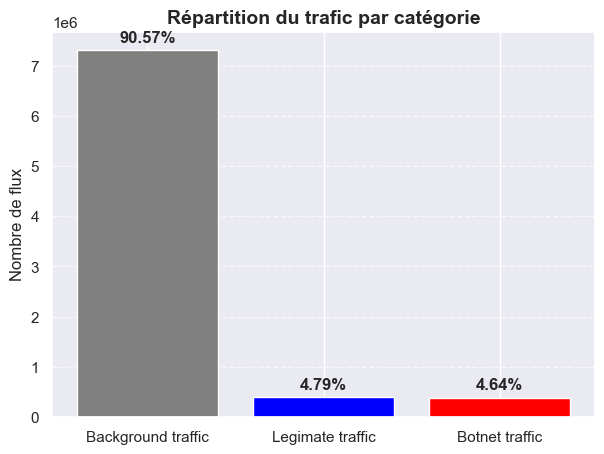

In [8]:
hist_of_label_values(df)

In [9]:
pd.DataFrame(df[df["Label"] == "Botnet"]["SrcIP"].value_counts()).head(20)

,count
SrcIP,
147.32.80.9,108534
147.32.84.165,28677
147.32.84.192,24873
147.32.84.191,23344
147.32.84.204,23197
147.32.84.206,23126
147.32.84.193,22775
147.32.84.205,22289
147.32.84.208,22258


## 4. Fonction `XU_algorithm`
Cette fonction va :
1. Agréger par IP source.
2. Calculer l'entropie normalisée (ports source, ports destination, IP destination).
3. Calculer le score `score = H(DstIP) - H(DstPort)`.
4. Déterminer un seuil via le quantile (par défaut 95ᵉ percentile).
5. Retourner un DataFrame par IP avec colonnes d'entropie, le score, la prédiction, etc.

In [31]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

def normalized_entropy(series):
    counts = series.value_counts(normalize=True, dropna=False)
    entropy = -(counts * np.log2(counts + 1e-12)).sum()
    distinct = len(counts)
    total_samples = len(series)
    if distinct <= 1 or total_samples <= 1:
        return 0.0
    max_entropy = np.log2(min(distinct, total_samples))
    return float(entropy / max_entropy)

def XU_algorithm(df, time_window='2Min'):
    """
    Algorithme XU sans classification directe (sans threshold).
    Retourne un DataFrame avec les RU, distances et anomaly score.
    La classification est faite ensuite par une fonction externe.
    """

    print("[1/4] ➤ Conversion de la colonne 'flow_start' en datetime...")
    df['flow_start'] = pd.to_datetime(df['flow_start'], format='%H:%M:%S.%f', errors='coerce')

    print("[2/4] ➤ Attribution des fenêtres temporelles...")
    df['TimeWindow'] = df['flow_start'].dt.floor(time_window)

    results = []

    # Profils de référence (serveur, client lourd, profil nul)
    ref_server = np.array([0.2, 0.9, 0.5])
    ref_client = np.array([0.9, 0.2, 0.2])
    ref_zero = np.zeros(3)

    time_windows = list(df.groupby('TimeWindow'))
    print(f"[3/4] ➤ Début du traitement sur {len(time_windows)} fenêtres temporelles...")

    for time_bin, df_time in tqdm(time_windows, desc='Fenêtres temporelles'):
        ip_groups = list(df_time.groupby('SrcIP'))

        for src_ip, df_src in tqdm(ip_groups, desc=f'    IPs dans {time_bin}', leave=False):
            ru_srcport = normalized_entropy(df_src['SrcPort'].fillna('N/A'))
            ru_dstport = normalized_entropy(df_src['DstPort'].fillna('N/A'))
            ru_dstip = normalized_entropy(df_src['DstIP'].fillna('N/A'))

            # Déterminer le label réel
            true_labels = df_src['Label'].unique()
            if 'Botnet' in true_labels:
                label = 'Botnet'
            elif 'LEGITIMATE' in true_labels:
                label = 'LEGITIMATE'
            else:
                label = 'Background'

            ru_vector = np.array([ru_srcport, ru_dstport, ru_dstip])
            d_server = np.linalg.norm(ru_vector - ref_server)
            d_client = np.linalg.norm(ru_vector - ref_client)
            d_zero = np.linalg.norm(ru_vector - ref_zero)
            mean_distance = (d_server + d_client + d_zero) / 3

            results.append({
                'TimeWindow': time_bin,
                'SrcIP': src_ip,
                'RU_SrcPort': ru_srcport,
                'RU_DstPort': ru_dstport,
                'RU_DstIP': ru_dstip,
                'Distance_Server': d_server,
                'Distance_Client': d_client,
                'Distance_Zero': d_zero,
                'Mean_Distance': mean_distance,
                'AnomalyScore': mean_distance,
                'Label': label
            })

    print("[4/4] ✅ Fin de l'algorithme XU. Distances prêtes.")
    df_features = pd.DataFrame(results)
    return df_features


def apply_threshold(df_features, threshold=0.5):
    """
    Applique un seuil de classification sur les distances déjà calculées.
    Ajoute/Met à jour la colonne 'Predicted' dans df_features.
    """
    df = df_features.copy()
    df['Predicted'] = df['Mean_Distance'].apply(lambda d: 'Botnet' if d > threshold else 'Normal')
    return df


## 5. Application
On applique `XU_algorithm` à notre DataFrame `df`, puis on regarde le résultat.

In [40]:
df_features = XU_algorithm(df[7500000:], time_window='2Min')

[1/4] ➤ Conversion de la colonne 'flow_start' en datetime...
[2/4] ➤ Attribution des fenêtres temporelles...
[3/4] ➤ Début du traitement sur 13 fenêtres temporelles...


C:\Users\kira\AppData\Local\Temp\ipykernel_17820\2200504370.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['flow_start'] = pd.to_datetime(df['flow_start'], format='%H:%M:%S.%f', errors='coerce')
C:\Users\kira\AppData\Local\Temp\ipykernel_17820\2200504370.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TimeWindow'] = df['flow_start'].dt.floor(time_window)


Fenêtres temporelles:   0%|          | 0/13 [00:00<?, ?it/s]

    IPs dans 2025-03-13 16:48:00:   0%|          | 0/1773 [00:00<?, ?it/s]

    IPs dans 2025-03-13 16:50:00:   0%|          | 0/7884 [00:00<?, ?it/s]

    IPs dans 2025-03-13 16:52:00:   0%|          | 0/7702 [00:00<?, ?it/s]

    IPs dans 2025-03-13 16:54:00:   0%|          | 0/7640 [00:00<?, ?it/s]

    IPs dans 2025-03-13 16:56:00:   0%|          | 0/7827 [00:00<?, ?it/s]

    IPs dans 2025-03-13 16:58:00:   0%|          | 0/7415 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:00:00:   0%|          | 0/7582 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:02:00:   0%|          | 0/7360 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:04:00:   0%|          | 0/7241 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:06:00:   0%|          | 0/7331 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:08:00:   0%|          | 0/6830 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:10:00:   0%|          | 0/6745 [00:00<?, ?it/s]

    IPs dans 2025-03-13 17:12:00:   0%|          | 0/1222 [00:00<?, ?it/s]

[4/4] ✅ Fin de l'algorithme XU. Distances prêtes.


In [41]:
df_classified = apply_threshold(df_features, threshold=0.7)
df_classified.head(10)

,TimeWindow,SrcIP,RU_SrcPort,RU_DstPort,RU_DstIP,Distance_Server,Distance_Client,Distance_Zero,Mean_Distance,AnomalyScore,Label,Predicted
0,2025-03-13 16:48:00,0,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
1,2025-03-13 16:48:00,1.38.189.0,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
2,2025-03-13 16:48:00,1.66.102.202,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
3,2025-03-13 16:48:00,1.85.178.162,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
4,2025-03-13 16:48:00,101.50.152.204,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
5,2025-03-13 16:48:00,108.128.128.65,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
6,2025-03-13 16:48:00,108.23.71.151,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
7,2025-03-13 16:48:00,108.54.87.64,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
8,2025-03-13 16:48:00,108.65.29.159,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal
9,2025-03-13 16:48:00,108.69.25.225,0.0,0.0,0.0,1.048809,0.943398,0.0,0.664069,0.664069,Background,Normal


In [42]:
def display_botnet_anomaly_scores(df_features):
    """
    Affiche les scores d'anomalie des adresses IP taguées comme Botnet sous forme de tableau.

    Paramètre :
    - df_features : DataFrame contenant les colonnes 'SrcAddr', 'AnomalyScore' et 'Label'.

    Affichage :
    - Un tableau des adresses IP Botnet avec leurs scores d'anomalie.
    """

    # Filtrer uniquement les adresses taguées comme Botnet
    botnet_scores_df = df_features[df_features['Label'] == 'Botnet'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)

    return botnet_scores_df

botnet_scores_df = display_botnet_anomaly_scores(df_classified)
botnet_scores_df

,SrcIP,AnomalyScore
0,14.97.21.87,0.664069
1,147.32.80.9,0.931476
2,147.32.84.165,1.041994
3,147.32.84.191,0.941940
4,147.32.84.192,1.007509
...,...,...
791,204.12.208.59,0.664069
792,212.117.177.186,0.664069
793,50.7.244.234,0.664069
794,64.4.56.135,0.664069


## 6. Évaluation
On compare la prédiction par IP (`Predicted`) avec le label vrai (`Label`), puis on calcule éventuellement la matrice de confusion au **niveau IP**. Après, on peut mapper cette prédiction sur chaque flux si on le souhaite (host → flows).

In [48]:
def compute_time_weighted_metrics(df_features, alpha=0.01):
    """
    Calcule les métriques réseau temporellement pondérées + métriques classiques (FPR, TPR, etc.)
    pour la sortie de l'algorithme XU.

    Paramètres :
    - df_features : DataFrame issu de XU_algorithm (avec colonnes TimeWindow, SrcIP, Label, Predicted)
    - alpha : paramètre de pondération temporelle pour la correcting function

    Retour :
    - df_metrics : DataFrame des métriques calculées par fenêtre temporelle
    - average_metrics : dictionnaire des moyennes globales (tTP, tFN, tFP, tTN + FPR, TPR, etc.)
    """

    metrics = []
    df_features = df_features.copy()

    # 🔁 Harmonisation des labels : tout sauf Botnet devient Normal
    df_features['Label'] = df_features['Label'].replace({'LEGITIMATE': 'Normal', 'Background': 'Normal'})

    # 🔁 Ordre des fenêtres temporelles
    unique_windows = sorted(df_features['TimeWindow'].unique())
    window_index_map = {w: i for i, w in enumerate(unique_windows)}

    for window in unique_windows:
        df_win = df_features[df_features['TimeWindow'] == window]
        idx = window_index_map[window]

        correcting_weight = np.exp(-alpha * idx) + 1

        # Grouper par IP pour déterminer les vrais/pred labels
        true_labels = df_win.groupby('SrcIP')['Label'].agg(
            lambda x: 'Botnet' if 'Botnet' in x.values else 'Normal'
        )
        pred_labels = df_win.groupby('SrcIP')['Predicted'].agg(
            lambda x: 'Botnet' if 'Botnet' in x.values else 'Normal'
        )

        c_TP = ((true_labels == 'Botnet') & (pred_labels == 'Botnet')).sum()
        c_TN = ((true_labels == 'Normal') & (pred_labels == 'Normal')).sum()
        c_FP = ((true_labels == 'Normal') & (pred_labels == 'Botnet')).sum()
        c_FN = ((true_labels == 'Botnet') & (pred_labels == 'Normal')).sum()

        n_botnet_ips = max((true_labels == 'Botnet').sum(), 1)
        n_normal_ips = max((true_labels == 'Normal').sum(), 1)

        # Métriques pondérées
        tTP = (c_TP * correcting_weight) / n_botnet_ips
        tFN = (c_FN * correcting_weight) / n_botnet_ips
        tFP = c_FP / n_normal_ips
        tTN = c_TN / n_normal_ips

        # Métriques classiques à partir des métriques pondérées
        FPR = tFP / (tTN + tFP) if (tTN + tFP) != 0 else 0
        TPR = tTP / (tTP + tFN) if (tTP + tFN) != 0 else 0
        TNR = tTN / (tTN + tFP) if (tTN + tFP) != 0 else 0
        FNR = tFN / (tTP + tFN) if (tTP + tFN) != 0 else 0
        Precision = tTP / (tTP + tFP) if (tTP + tFP) != 0 else 0
        Accuracy = (tTP + tTN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        ErrorRate = (tFP + tFN) / (tTP + tTN + tFP + tFN) if (tTP + tTN + tFP + tFN) != 0 else 0
        F1 = (2 * Precision * TPR) / (Precision + TPR) if (Precision + TPR) != 0 else 0

        metrics.append({
            'TimeWindow': window,
            'c_TP': c_TP, 'c_FN': c_FN, 'c_FP': c_FP, 'c_TN': c_TN,
            'tTP': tTP, 'tFN': tFN, 'tFP': tFP, 'tTN': tTN,
            'FPR': FPR, 'TPR': TPR, 'TNR': TNR, 'FNR': FNR,
            'Precision': Precision, 'Accuracy': Accuracy,
            'ErrorRate': ErrorRate, 'F1_Score': F1
        })

    df_metrics = pd.DataFrame(metrics)

    # Moyennes globales
    average_metrics = {
        'Avg_tTP': df_metrics['tTP'].mean(),
        'Avg_tFN': df_metrics['tFN'].mean(),
        'Avg_tFP': df_metrics['tFP'].mean(),
        'Avg_tTN': df_metrics['tTN'].mean(),
        'Avg_FPR': df_metrics['FPR'].mean(),
        'Avg_TPR': df_metrics['TPR'].mean(),
        'Avg_TNR': df_metrics['TNR'].mean(),
        'Avg_FNR': df_metrics['FNR'].mean(),
        'Avg_Precision': df_metrics['Precision'].mean(),
        'Avg_Accuracy': df_metrics['Accuracy'].mean(),
        'Avg_ErrorRate': df_metrics['ErrorRate'].mean(),
        'Avg_F1_Score': df_metrics['F1_Score'].mean()
    }

    return df_metrics, average_metrics


In [52]:
# df_features = XU_algorithm_time_window(df_binetflow, threshold=0.5, time_window='2Min')
df_metrics, avg_metrics = compute_time_weighted_metrics(df_classified, alpha=0.01)

display(df_metrics.head())
import json

print(json.dumps(avg_metrics, indent=4))



,TimeWindow,c_TP,c_FN,c_FP,c_TN,tTP,tFN,tFP,tTN,FPR,TPR,TNR,FNR,Precision,Accuracy,ErrorRate,F1_Score
0,2025-03-13 16:48:00,22,13,201,1537,1.257143,0.742857,0.115650,0.884350,0.115650,0.628571,0.884350,0.371429,0.915756,0.713831,0.286169,0.745461
1,2025-03-13 16:50:00,47,36,636,7165,1.126896,0.863154,0.081528,0.918472,0.081528,0.566265,0.918472,0.433735,0.932534,0.684058,0.315942,0.704646
2,2025-03-13 16:52:00,44,39,654,6965,1.049744,0.930455,0.085838,0.914162,0.085838,0.530120,0.914162,0.469880,0.924411,0.658985,0.341015,0.673824
3,2025-03-13 16:54:00,46,34,652,6908,1.133006,0.837439,0.086243,0.913757,0.086243,0.575000,0.913757,0.425000,0.929265,0.689042,0.310958,0.710417
4,2025-03-13 16:56:00,44,38,705,7040,1.052131,0.908659,0.091026,0.908974,0.091026,0.536585,0.908974,0.463415,0.920373,0.662359,0.337641,0.677931


{
    "Avg_tTP": 1.0531699558290617,
    "Avg_tFN": 0.8892539502828747,
    "Avg_tFP": 0.089241921243997,
    "Avg_tTN": 0.9107580787560029,
    "Avg_FPR": 0.089241921243997,
    "Avg_TPR": 0.5409023857943649,
    "Avg_TNR": 0.9107580787560029,
    "Avg_FNR": 0.45909761420563505,
    "Avg_Precision": 0.856939760519097,
    "Avg_Accuracy": 0.6669184642545006,
    "Avg_ErrorRate": 0.3330815357454992,
    "Avg_F1_Score": 0.6622740463296216
}


# I don't know

In [143]:
def display_confusion_matrix(y_true, y_pred):
    """
    Affiche un tableau structuré avec les métriques de classification :
    TP, TN, FP, FN et le rapport de classification détaillé.

    Paramètres :
    - y_true : Liste des vraies étiquettes (Normal/Botnet)
    - y_pred : Liste des prédictions du modèle (Normal/Botnet)
    """
    
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=['Normal', 'Botnet'])
    print(cm)
    # Extraction des valeurs TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    
    # Création d'un DataFrame pour afficher sous forme de tableau 2x2
    confusion_df = pd.DataFrame(
        [[f"TN: {tn}", f"FP: {fp}"],
         [f"FN: {fn}", f"TP: {tp}"]],
        index=["Actual Normal", "Actual Botnet"],
        columns=["Predicted Normal", "Predicted Botnet"]
    )

    # Affichage du tableau
    print("\n📊 **Matrice de Confusion & Résumé des métriques**")
    display(confusion_df)
    
    # Génération du rapport de classification
    classification_rep = classification_report(y_true, y_pred, labels=['Normal', 'Botnet'], output_dict=True)
    classification_df = pd.DataFrame(classification_rep).transpose()

    # Affichage du rapport détaillé
    print("\n📑 **Rapport de Classification**")
    display(classification_df)


In [145]:
y_true = df_features['Label']
y_pred = df_features['Predicted']

display_confusion_matrix(y_true, y_pred)

[[310823  27357]
 [   239    460]]

📊 **Matrice de Confusion & Résumé des métriques**


,Predicted Normal,Predicted Botnet
Actual Normal,TN: 310823,FP: 27357
Actual Botnet,FN: 239,TP: 460



📑 **Rapport de Classification**


,precision,recall,f1-score,support
Normal,0.999232,0.919105,0.957495,338180.000000
Botnet,0.016537,0.658083,0.032263,699.000000
accuracy,0.918567,0.918567,0.918567,0.918567
macro avg,0.507884,0.788594,0.494879,338879.000000
weighted avg,0.997205,0.918567,0.955587,338879.000000


### Flow-level metrics
Si l'on veut évaluer plus finement au niveau **flow** :
1. Merge `df_features` dans `df` sur la colonne `SrcAddr`.
2. Si un IP est classé Botnet, tous ses flux deviennent Botnet.
3. On compare `df['Label']` et `df['PredictedFlow']`.

In [124]:
# 1. Merge
df_merged = df.merge(df_features[['SrcIP','Predicted']], on='SrcIP', how='left')
df_merged['PredictedFlow'] = df_merged['Predicted']

# 2. On compare
y_true_fl = df_merged['Label']
y_pred_fl = df_merged['PredictedFlow']

cm_fl = confusion_matrix(y_true_fl, y_pred_fl, labels=['Normal','Botnet'])
tn, fp, fn, tp = cm_fl.ravel()

print("Matrice de confusion (Flow-level) :")
print(cm_fl)
print(classification_report(y_true_fl, y_pred_fl, labels=['Normal','Botnet']))

Matrice de confusion (Flow-level) :
[[     0      0]
 [374468    577]]


KeyboardInterrupt: 

In [ ]:
def plot_anomaly_score_histogram_with_counts(df_features):
    """
    Affiche un histogramme de la distribution des scores d'anomalie (AnomalyScore) 
    avec les nombres d'occurrences affichés sur chaque barre.

    Paramètre :
    - df_features : DataFrame contenant une colonne 'AnomalyScore'.

    Affichage :
    - Un histogramme montrant la répartition des scores d'anomalie avec les effectifs sur les barres.
    """

    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(df_features['AnomalyScore'], bins=30, color='blue', edgecolor='black', alpha=0.7)

    # Ajouter les étiquettes de fréquence au-dessus des barres
    for count, bin_patch in zip(counts, patches):
        if count > 0:  # Éviter d'afficher les valeurs nulles
            plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count, 
                     f"{int(count)}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('Distribution des Scores d\'Anomalie', fontsize=14, fontweight='bold')
    plt.xlabel('AnomalyScore', fontsize=12)
    plt.ylabel('Nombre d\'occurrences', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

plot_anomaly_score_histogram_with_counts(df_features)


In [ ]:
def display_botnet_anomaly_scores(df_features):
    """
    Affiche les scores d'anomalie des adresses IP taguées comme Botnet sous forme de tableau.

    Paramètre :
    - df_features : DataFrame contenant les colonnes 'SrcAddr', 'AnomalyScore' et 'Label'.

    Affichage :
    - Un tableau des adresses IP Botnet avec leurs scores d'anomalie.
    """

    # Filtrer uniquement les adresses taguées comme Botnet
    botnet_scores_df = df_features[df_features['Label'] == 'Botnet'][['SrcIP', 'AnomalyScore']].reset_index(drop=True)

    return botnet_scores_df

botnet_scores_df = display_botnet_anomaly_scores(df_features)
botnet_scores_df